### Goal: Interaction and regulatory sites identification

In [1]:
import pandas as pd
import requests
from Bio import SeqIO
import numpy as np
import gemmi as gm
from utils import read_GEMME_mat, alph, bfactorsPDB, ResidueSensitivityGEMME
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt

In [ ]:
WORK_DIR = os.path.dirname(os.path.abspath('')) + os.sep

## dataframe with prediction data information
df_Dmel_recap = pd.read_csv(f'{WORK_DIR}/csv/'+'Dmel6.44PredictionsRecap.csv', index_col=0)
df_Dmel_recap_Conf = df_Dmel_recap.loc[df_Dmel_recap['GEMME_GlobalConfidence']==True].copy() 

## dictionnary with protein sequences
dc_protein_seqs = SeqIO.to_dict(SeqIO.parse(f'{WORK_DIR}/csv/'+'dmel-all-translation-r6.44.fasta', "fasta"))  

## GEMME local confidence 
df_Confidence = pd.read_csv(f'{WORK_DIR}/csv/ConfidenceLocal_pLDDT.csv', index_col=0)
df_Confidence['NonConf_Residues'] = df_Confidence['NonConf_Residues'].apply(lambda x: eval(x) if pd.notna(x) else None)

## dataframe with mapping information
df_mapping = pd.read_csv(f'{WORK_DIR}/csv/mapping_database.csv', index_col=0)
## ProteoCast Benchmark
df_ProteoCast_Benchmark = pd.read_csv(f'{WORK_DIR}/csv/'+'ProteoCast_Benchmark.csv')

## Retreiving Post Transcriptional Modifications (PTMs) data from **iproteindb** https://www.flyrnai.org/tools/iproteindb/web/  

In [ ]:

# Base URL for the API
base_url = "https://www.flyrnai.org/tools/iproteindb/web/protein_api/"

# Make a GET request to fetch the protein details
for batch in range(0, 5):
    data = []
    for proteoform in df_Dmel_recap.loc[df_Dmel_recap['Representative_FBpp']==True].index.tolist()[x*5000:(x+1)*5000]:

        FBpp = df_Dmel_recap.loc[df_Dmel_recap['Protein_symbol']==proteoform].index[0]

        # Make a GET request to fetch the protein details
        response = requests.get(f'{base_url}{FBpp}/')

        # Check if the response is successful
        if response.status_code == 200:
            try:
                # Parse and print the JSON response
                protein_details = response.json()
                data.extend(protein_details['PTM Data'])
            except requests.exceptions.JSONDecodeError:
                print("Error: Response content is not valid JSON")
                print("Response content:", response.text)
        else:
            print(f"Error: Received status code {response.status_code}")
            print("Response content:", response.text)

    df = pd.DataFrame(data)
    del df['source']
    df.to_csv(f'PTM_{batch+1}.csv')
    del df

## PTM data overview

64318 PTMs in 8144 representative FBpp among 4029 genes. 
157 FBpp doesn't have a protein 3D prediction either missing from alphafolddb or were not generated as very long (thresh <=4000aa) 

In [6]:
df_PTM_proteome = pd.read_csv('../csv/PTM.csv')
df_PTM_proteome = df_PTM_proteome.merge(df_Dmel_recap[['FBgn_ID','Length', 'Representative_FBpp', 'GEMME_GlobalConfidence', 'Structure_3D_file' ]], left_on='FBpp_ID', right_index=True)
df_PTM_proteomeConf = df_PTM_proteome.loc[df_PTM_proteome['GEMME_GlobalConfidence']==True].copy()

In [172]:
df_PTM_proteome = pd.read_csv('../csv/PTM.csv')
df_PTM_proteome = df_PTM_proteome.merge(df_Dmel_recap[['FBgn_ID','Length', 'Representative_FBpp', 'GEMME_GlobalConfidence', 'Structure_3D_file' ]], left_on='FBpp_ID', right_index=True)
print(df_PTM_proteome['FBpp_ID'].nunique(), df_PTM_proteome['FBgn_ID'].nunique())

8530 4276


In [ ]:
print("Number of PTMs", df_PTM_proteomeConf.shape)
print('number of proteins with annotated PTMs', df_PTM_proteomeConf['FBpp_ID'].nunique())
print('in ', df_PTM_proteomeConf['FBgn_ID'].nunique(), 'genes')
print('we have structures for ', df_PTM_proteomeConf.loc[~df_PTM_proteomeConf['Structure_3D_file'].isnull(), 'FBpp_ID'].nunique(), 'proteins')
print("\nthe following PTMs were retreived (and their fraction):")
df_PTM_proteomeConf['modification'].value_counts(normalize=True)


Number of PTMs (64318, 10)
number of proteins with annotated PTMs 8144
in  4029 genes
we have structures for  7987 proteins

the folllowing PTMs were retreived (and their fraction):


modification
Phosphorylation    0.916695
Acetylation        0.044840
Oxidation          0.038465
Name: proportion, dtype: float64

### <span style="color:#CBAACB"> - number of PTMs per protein</span>

In [8]:
nbPTM_perProt = df_PTM_proteomeConf['FBpp_ID'].value_counts().reset_index()
nbPTM_perProt.columns = ['FBpp_ID', 'PTM_Count']
nbPTM_perProt['PTM_Count'].describe()

count    8144.000000
mean        7.897593
std        10.504226
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        88.000000
Name: PTM_Count, dtype: float64

## Add Local and Global Sensitivity. And pLDDT where possible

In [247]:
df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_4.csv')
print(df_Segmentation['protein'].nunique())
df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
print(df_Segmentation['FBpp_ID'].nunique())
df_Segmentation

22169
8144


,start,end,mean,state,type,FBpp_ID
102,1,2,0.098325,2,GEMME,FBpp0070006
103,3,12,0.038952,1,GEMME,FBpp0070006
104,13,25,0.010332,0,GEMME,FBpp0070006
105,26,39,0.034317,1,GEMME,FBpp0070006
106,40,51,0.186928,1,GEMME,FBpp0070006
...,...,...,...,...,...,...
1011121,297,314,0.282346,1,GEMME,FBpp0402906
1011122,315,331,0.136219,0,GEMME,FBpp0402906
1011123,332,367,0.547079,2,GEMME,FBpp0402906
1011124,368,408,0.245513,0,GEMME,FBpp0402906


In [20]:
# Create a dico with ProteoCast data for a specifi set of FBpp_ID
def create_gemme_dico(df):
    gemme_data = {}
    for fbpp_id in df['FBpp_ID'].unique():
        id = df_mapping.loc[fbpp_id, 'id']
        try:
            gemme_data[fbpp_id] = pd.read_csv(f'../Drosophila_ProteoCast/{id}/4.{fbpp_id}_ProteoCast.csv')
        except: 
            continue
    return gemme_data

def get_state_for_position(df, position, metric='state', type='GEMME'):
    row = df[(df['start'] <= position) & (df['end'] >= position)&(df['type']==type)]
    if not row.empty:
        return round(row.iloc[0][metric], 3)
    return None
def ptm_sensitivity(row, df_Segmentation, gemme_data):
    prot = row['FBpp_ID']
    residue = row['position']
    local_sens = get_state_for_position(df_Segmentation, residue)
    global_sens = gemme_data[prot].loc[gemme_data[prot]['Residue']==residue, 'Residue_class'].values[0]
    return local_sens, global_sens

def addLocalConf(row, gemme_data):
    prot = row['FBpp_ID']
    residue = row['position']
    conf = gemme_data[prot].loc[gemme_data[prot]['Residue']==residue, 'GEMME_LocalConfidence'].values[0]
    return conf
def pLDDT_addSensitivity(row, gemme_data):
    prot = row['FBpp_ID']
    residue = row['position']
    if 'pLDDT' in gemme_data[prot].columns:
        plddt = gemme_data[prot].loc[gemme_data[prot]['Residue']==residue, 'pLDDT'].values[0]
        return plddt*100
    else:
        return None

In [249]:
gemme_data = create_gemme_dico(df_PTM_proteomeConf)

gemme_data_plddt = {}
for fbpp_id in df_PTM_proteomeConf['FBpp_ID'].unique():
    try:
        gemme_data_plddt[fbpp_id] = pd.read_csv(f'../Seg/{fbpp_id}_GEMME_pLDDT.csv')
    except: 
        continue

In [2]:
tmp.columns

Index(['Unnamed: 0', 'FBpp_ID', 'position', 'AA', 'modification', 'count',
       'FBgn_ID', 'Length', 'Representative_FBpp', 'GEMME_GlobalConfidence',
       'Structure_3D_file', 'Local_Sensitivity', 'Global_Sensitivity',
       'GEMME_LocalConfidence', 'pLDDT'],
      dtype='object')

In [7]:
import pandas as pd 
tmp = pd.read_csv('../csv/PTM_proteomeSensitivity1_4.csv')
#tmp['pLDDT'] = tmp['pLDDT'].apply(lambda x: round(x) if pd.notna(x) else None).astype(pd.Int64Dtype())
#tmp.rename(columns={'GEMME_LocalConfidence':'LocalConfidence', 'GEMME_GlobalConfidence':'GlobalConfidence'}, inplace=True)

In [6]:
tmp.to_csv('../csv/PTM_proteomeSensitivity1_4.csv', index=False)

In [13]:
tmp = pd.read_csv('/Users/manchuta/Desktop/csv/PTM_proteomeSensitivity1_4.csv')
del tmp['Representative_FBpp']

In [15]:
tmp.to_csv('/Users/manchuta/Desktop/csv/PTM_proteomeSensitivity1_4.csv', index=False)

In [27]:
df_PTM_proteomeConf[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_proteomeConf.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
df_PTM_proteomeConf[['GEMME_LocalConfidence']] = df_PTM_proteomeConf.apply(lambda row: pd.Series(addLocalConf(row, gemme_data)), axis=1)
df_PTM_proteomeConf[['pLDDT']] = df_PTM_proteomeConf.apply(lambda row: pd.Series(pLDDT_addSensitivity(row, gemme_data_plddt)), axis=1)

In [ ]:
df_PTM_proteomeConf.to_csv(f'{WORK_DIR}/csv/PTM_proteomeSensitivity1_4.csv')

for 3890 we don't have plddt score

In [21]:
def SensitivityPerf(df_PTM_proteomeConf):
    print('(PTM in pLDDT<70)/PTM = ', round(df_PTM_proteomeConf.loc[df_PTM_proteomeConf['pLDDT'] < 70].shape[0] / df_PTM_proteomeConf.shape[0] * 100, 2), df_PTM_proteomeConf.loc[df_PTM_proteomeConf['pLDDT'] < 70].shape[0])
    print('(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Global_Sensitivity'] == 'sensitive')].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2), 
          df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Global_Sensitivity'] == 'sensitive')].shape[0])
    print('(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Local_Sensitivity'] != 0)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2), 
          df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Local_Sensitivity'] != 0)].shape[0])
    print('(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Local_Sensitivity'] == 1)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2))
    print('(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Local_Sensitivity'] == 2)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2))

    ## union and exclusive
    print('(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Global_Sensitivity'] == 'sensitive') & (df_PTM_proteomeConf['Local_Sensitivity'] != 0)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2))
    print('(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['GEMME_LocalConfidence'] == True)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2))
    ## exclusive
    print('(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) = ', round(df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70) & (df_PTM_proteomeConf['Global_Sensitivity'] == 'sensitive') & (df_PTM_proteomeConf['Local_Sensitivity'] != 0)].shape[0] / df_PTM_proteomeConf.loc[(df_PTM_proteomeConf['pLDDT'] < 70)].shape[0] * 100, 2))

In [33]:
df_PTM_proteomeConf3D = df_PTM_proteomeConf.loc[~df_PTM_proteomeConf['Structure_3D_file'].isnull()].copy()
print('all', df_PTM_proteomeConf.shape, df_PTM_proteomeConf3D.shape) 

all (64318, 14) (60428, 14)


In [34]:
SensitivityPerf(df_PTM_proteomeConf3D)

(PTM in pLDDT<70)/PTM =  88.93 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  64.13 34461
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  22.52
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  41.61
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.55
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.55


## test on other alpha parameters

In [95]:
for x in [2,3,4,5,6,7, 8, 9]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_{x}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 2
(PTM in pLDDT<70)/PTM =  83.55
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  60.75
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  19.89
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  40.86
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.34
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.34
alpha 4
(PTM in pLDDT<70)/PTM =  83.55
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  64.13
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  22.52
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  41.61
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.55
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.55
alpha 5
(PTM in pLDDT<70)/PTM =  83.55
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  63.85
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  22.34
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  41.51
(PTM_SensG & 

In [250]:
for x in [3]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_{x}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 3
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  63.02 33866
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  22.9
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  40.12
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.18
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  25.18


In [125]:
for x in [6]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_{x}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 6
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  61.37 32981
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  20.33
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  41.05
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.89
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.89


In [158]:
for x in [7]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_{x}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 7
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  59.95 32218
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  19.16
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  40.79
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.41
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  24.41


In [87]:
for x in [8,9]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_{x}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 8
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  57.92 31123
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  18.97
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  38.95
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  23.54
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  23.54
alpha 9
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  54.88 29490
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  15.91
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  38.97
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  22.17
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  22.17


In [159]:
for x in [2]:
    print('alpha', x)
    df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a{2}.csv')
    df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_PTM_proteomeConf['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
    df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
    df_PTM_tmp = df_PTM_proteomeConf.copy() 
    df_PTM_tmp[['Local_Sensitivity', 'Global_Sensitivity']] = df_PTM_tmp.apply(lambda row: pd.Series(ptm_sensitivity(row, df_Segmentation, gemme_data)), axis=1)
    SensitivityPerf(df_PTM_tmp)

alpha 2
(PTM in pLDDT<70)/PTM =  83.55 53737
(PTM_SensG in pLDDT<70)/(PTM in pLDDT<70) =  38.94 20923
(PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  54.46 29266
(PTM_SensL1 in pLDDT<70)/(PTM in pLDDT<70) =  15.24
(PTM_SensL2 in pLDDT<70)/(PTM in pLDDT<70) =  39.22
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  22.01
(PTM_HighConf in pLDDT<70)/(PTM in pLDDT<70) =  97.85
(PTM_SensG & PTM_SensL in pLDDT<70)/(PTM in pLDDT<70) =  22.01


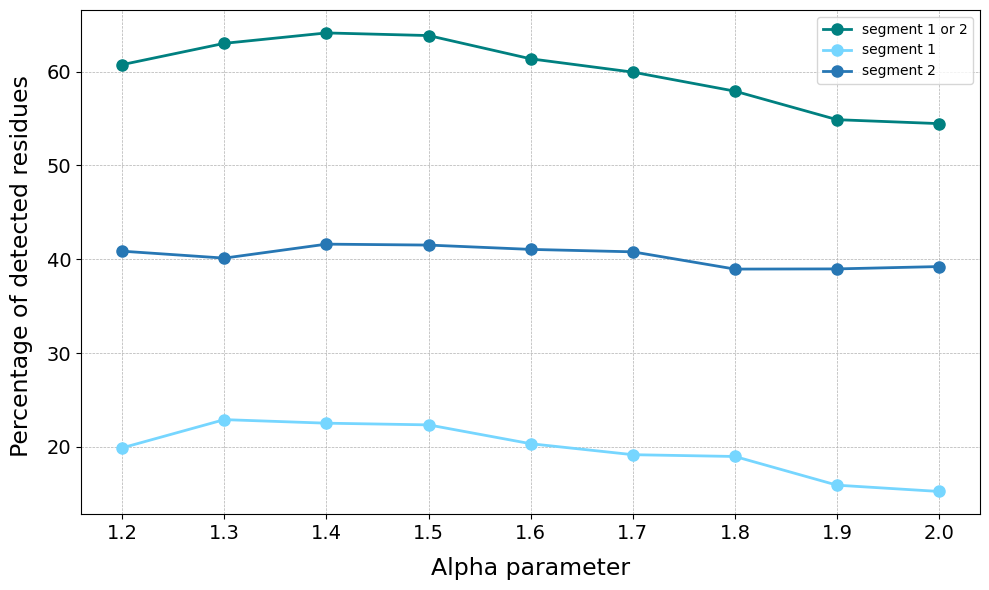

In [257]:
plt.figure(figsize=(10, 6))
plt.plot([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], [60.75, 63.02, 64.13, 63.85, 61.37, 59.95, 57.92, 54.88, 54.46], marker='o', linestyle='-', color='teal', linewidth=2, markersize=8, label='segment 1 or 2')
plt.plot([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], [19.89, 22.9, 22.52, 22.34, 20.33, 19.16, 18.97, 15.91, 15.24], marker='o', linestyle='-', color='#76D6FF', linewidth=2, markersize=8, label='segment 1')
plt.plot([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], [40.86, 40.12 , 41.61, 41.51, 41.05, 40.79, 38.95, 38.97, 39.22], marker='o', linestyle='-', color='#2777B4', linewidth=2, markersize=8, label='segment 2')

#plt.title('Percentage of sensitive residues', fontsize=16)
plt.xlabel('Alpha parameter', fontsize=17, labelpad=10)
plt.ylabel('Percentage of detected residues ', fontsize=17, labelpad=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig(f'{WORK_DIR}/Plots/SegAlphaParamBenchmark_seg1_2.jpg', dpi=400)
# Remove top and right borders
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

plt.show()

## Overlap between local and global sensitivity

In [202]:
overlap_df = df_PTM_proteomeConf3D[(df_PTM_proteomeConf3D['pLDDT']<70)&(df_PTM_proteomeConf3D['Global_Sensitivity'] == 'sensitive') & (df_PTM_proteomeConf3D['Local_Sensitivity']!= 0)]
union_sensitivity = df_PTM_proteomeConf3D[(df_PTM_proteomeConf3D['pLDDT']<70)&((df_PTM_proteomeConf3D['Global_Sensitivity'] == 'sensitive') | (df_PTM_proteomeConf3D['Local_Sensitivity']!= 0))]

# Calculate the overlap
overlap_count = overlap_df.shape[0]

print(f"Number of overlapping entries: {overlap_count}, all detected {union_sensitivity.shape[0]}") #41656
print(round(overlap_count/union_sensitivity.shape[0]*100, 3), '%')

Number of overlapping entries: 13728, all detected 41656
32.956 %


20923 34461


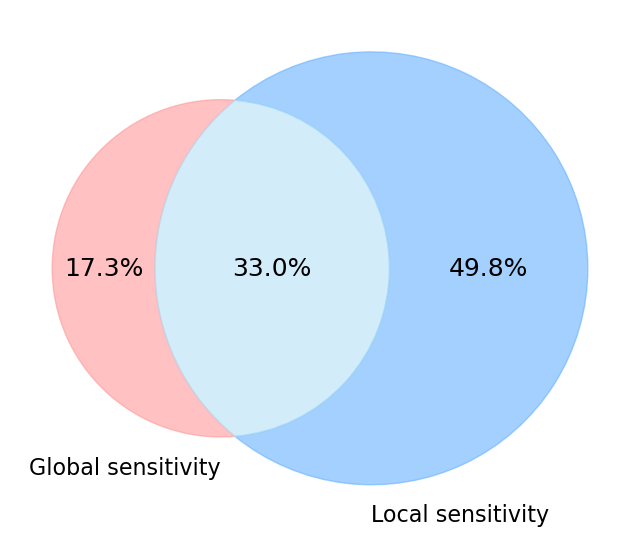

In [ ]:
# Example sets of residues for three groups
groupSensitiveG = set(df_PTM_proteomeConf3D[(df_PTM_proteomeConf3D['pLDDT']<70)&(df_PTM_proteomeConf3D['Global_Sensitivity'] == 'sensitive')].index)
groupSensitiveL = set(df_PTM_proteomeConf3D.loc[(df_PTM_proteomeConf3D['pLDDT']<70)& (df_PTM_proteomeConf3D['Local_Sensitivity']!=0)].index)

print(len(groupSensitiveG), len(groupSensitiveL))


# Plotting the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn2([groupSensitiveG, groupSensitiveL], ('Global sensitivity', 'Local sensitivity'),  alpha=0.5)


# Custom colors for each section
colors = {
    '100': '#FF9999',  # Only Local Sensitivity
    '010': '#66B2FF',  # Only Global Sensitivity
    '110': '#B4E0F7',  
}

for subset in colors:
    if venn.get_label_by_id(subset):  # If the subset exists
        venn.get_patch_by_id(subset).set_color(colors[subset])
        venn.get_patch_by_id(subset).set_alpha(0.6)  # Adjust transparency if needed



# Calculate the total number of elements
total_elements = len(groupSensitiveG | groupSensitiveL)

# Adjust the labels to show percentages
for idx, subset in enumerate(venn.subset_labels):
    if subset:  # Check if the subset label is not None
        count = int(subset.get_text())
        percentage = (count / total_elements) * 100
        subset.set_text(f'{percentage:.1f}%')

# Adjust the font size of the labels
for text in venn.set_labels:
    text.set_fontsize(16)

for text in venn.subset_labels:
    if text:  # Check if the text object is not None
        text.set_fontsize(18)
    
#plt.title("Venn Diagram of PTM Residues with Functional Signals in Different Groups", fontsize=16)
plt.savefig(f'{WORK_DIR}/Plots/VennDiagram_GlobalLocalSens_IDR.jpg', dpi=400)
plt.show()


In [224]:
df_PTM_proteomeConf3D.loc[(df_PTM_proteomeConf3D['pLDDT']<70)&(df_PTM_proteomeConf3D['GEMME_LocalConfidence']==True)].shape[0]

52582

Text(-0.3780498957846525, 0.3711027388729998, 'Global sensitivity') (-0.3780498957846525, 0.3711027388729998)
Text(0.33817985598630085, 0.47086230531543727, 'Local sensitivity') (0.33817985598630085, 0.47086230531543727)
Text(0.03669687749150074, -0.42794295565147966, '22.5%') (0.03669687749150074, -0.42794295565147966)
Text(-0.4037755780003352, 0.014269706080265388, '13.4%') (-0.4037755780003352, 0.014269706080265388)
Text(0.24587847172366714, 0.0014683647311037893, '38.6%') (0.24587847172366714, 0.0014683647311037893)


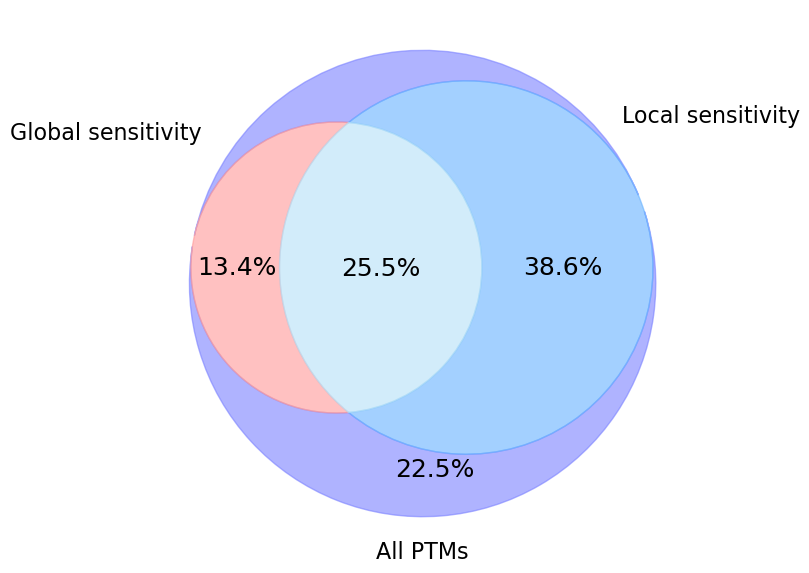

In [242]:
# Example sets of residues for three groups
groupSensitiveGEMME = set(df_PTM_proteomeConf3D.loc[(df_PTM_proteomeConf3D['pLDDT']<70)&(df_PTM_proteomeConf3D['Global_Sensitivity'] == 'sensitive')].index)
groupSegGEMME = set(df_PTM_proteomeConf3D.loc[(df_PTM_proteomeConf3D['pLDDT']<70)&(df_PTM_proteomeConf3D['Local_Sensitivity']!=0)].index)
groupAll = set(df_PTM_proteomeConf3D.loc[(df_PTM_proteomeConf3D['pLDDT']<70)].index)

# Plotting the Venn diagram with custom colors
plt.figure(figsize=(8, 8))
venn = venn3([groupSensitiveGEMME, groupSegGEMME, groupAll], ('Global sensitivity', 'Local sensitivity', 'All PTMs'))

# Custom colors for each section
colors = {
    '100': '#FF9999',  # Only Local Sensitivity
    '010': '#66B2FF',  # Only Global Sensitivity
    '001': '#7A81FF',  # Only All PTMs
    '110': '#B4E0F7',  # Local & Global Sensitivity
    '101': '#FF9999',  # Local Sensitivity & All PTMs
    '011': '#66B2FF',  # Global Sensitivity & All PTMs
    '111': '#B4E0F7',  # Intersection of all three  D6D6D6
}

for subset in colors:
    if venn.get_label_by_id(subset):  # If the subset exists
        venn.get_patch_by_id(subset).set_color(colors[subset])
        venn.get_patch_by_id(subset).set_alpha(0.6)  # Adjust transparency if needed

# Calculate the total number of elements
total_elements = len(groupAll)

# Adjust the labels to show percentages
for idx, subset in enumerate(venn.subset_labels):
    if subset:  # Check if the subset label is not None
        count = int(subset.get_text())
        percentage = (count / total_elements) * 100
        subset.set_text(f'{percentage:.1f}%')

    # Adjust the font size of the labels
for text in venn.set_labels:
    text.set_fontsize(16)

    if text.get_text()=='Global sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]-0.15, text.get_position()[1]-0.04))
        
    if text.get_text()=='Local sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]+0.15, text.get_position()[1]-0.1))


for text in venn.subset_labels:
    if text:  # Check if the text object is not None
        text.set_fontsize(18)
        if '22.5%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0], text.get_position()[1]-0.04))  # Adjust the position
        if '38.6%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0]+0.1, 0.02))  # Adjust the position
        if '13.4%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0]-0.04, 0.02))  # Adjust the position

plt.tight_layout()
#plt.title("Venn Diagram of PTM Residues with Functional Signals in Different Groups", fontsize=16)
plt.savefig(f'{WORK_DIR}/Plots/VennDiagram_GlobalLocalSens_IDR_AllPTMs.jpg', dpi=500)
plt.show()


## ELM database


In [138]:
df_ELM = pd.read_csv(f'{WORK_DIR}/data/elm_instances.tsv', sep='\t', skiprows =5)
#df_ELM=pd.read_csv('../csv/ELM_dataSensitivity.csv')

In [139]:
df_ELM = df_ELM[['Accession', 'ProteinName', 'Primary_Acc', 'Accessions', 'Start', 'End']].copy()
df_ELM['Length_SLIM'] = df_ELM['End'] - df_ELM['Start'] + 1
df_ELM.rename(columns={'Primary_Acc':'UniProt_ID'}, inplace=True)

In [140]:
df_Dmel_tmp = df_Dmel_recap.loc[df_Dmel_recap['Representative_FBpp']==True].copy()
df_Dmel_tmp['FBpp_ID'] = df_Dmel_tmp.index

In [141]:
df_ELM = df_ELM.merge(df_Dmel_tmp[['UniProt_ID', 'FBgn_ID', 'FBpp_ID', 'Length', 'GEMME_GlobalConfidence', 'Structure_3D_file']], on='UniProt_ID', how='left') 

In [142]:
df_ELM.loc[df_ELM['FBpp_ID'].isnull()].shape

(12, 12)

In [156]:
## to work with a subset of segmentation data
df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_4.csv')
print(df_Segmentation['protein'].nunique())
df_Segmentation = df_Segmentation.loc[(df_Segmentation['protein'].isin(df_ELM['FBpp_ID'].unique()))& (df_Segmentation['type']=='GEMME')].copy()
df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
print(df_Segmentation['FBpp_ID'].nunique())
df_Segmentation

22169
79


,start,end,mean,state,type,FBpp_ID
8062,1,18,0.570135,2,GEMME,FBpp0070347
8063,19,41,0.460659,1,GEMME,FBpp0070347
8064,42,46,0.116375,0,GEMME,FBpp0070347
8065,47,58,0.475641,2,GEMME,FBpp0070347
8066,59,84,0.322077,1,GEMME,FBpp0070347
...,...,...,...,...,...,...
1008758,583,620,0.303814,1,GEMME,FBpp0401445
1008759,621,635,0.082721,0,GEMME,FBpp0401445
1008760,636,642,0.225165,2,GEMME,FBpp0401445
1008761,643,659,0.079215,0,GEMME,FBpp0401445


In [159]:
gemme_data_plddt = {}
for fbpp_id in df_ELM['FBpp_ID'].unique():
    try:
        gemme_data_plddt[fbpp_id] = pd.read_csv(f'../Seg/{fbpp_id}_GEMME_pLDDT.csv')
    except: 
        continue
gemme_data = create_gemme_dico(df_ELM.loc[~df_ELM['FBpp_ID'].isnull()])

In [163]:
#########  Sensitivity & Segmentation  & Bfactors metrics to add to the ELM dataset         ########

for index, row in df_ELM.loc[~df_ELM['FBpp_ID'].isnull()].iterrows():
    FBpp = row['FBpp_ID']
    positions = list(np.arange(row['Start'], row['End']+1))

    l_localSens = [get_state_for_position(df_Segmentation.loc[df_Segmentation['FBpp_ID']==FBpp], pos) for pos in positions]
    l_globalSens = [gemme_data[FBpp].loc[gemme_data[FBpp]['Residue']==pos, 'Residue_class'].values[0] for pos in positions]
    df_ELM.loc[index, 'Global_Sensitivity'] = round(np.sum(np.isin(l_globalSens, ['sensitive'])) / len(l_globalSens), 2)
    df_ELM.loc[index, 'Local_Sensitivity'] = round(np.sum(np.isin(l_localSens, [1, 2])) / len(l_localSens), 2)
    
    ##pLDDT
    l_pLDDT = [gemme_data_plddt[FBpp].loc[gemme_data_plddt[FBpp]['Residue']==pos, 'pLDDT'].values[0] for pos in positions]
    df_ELM.loc[index, 'pLDDT'] = round(np.mean(l_pLDDT), 2)

    local_conf = [gemme_data[FBpp].loc[gemme_data[FBpp]['Residue']==pos, 'GEMME_LocalConfidence'].values[0] for pos in positions]
    df_ELM.loc[index, 'GEMME_LocalConfidence'] = round(np.sum(local_conf) / len(local_conf), 2)



In [164]:
df_ELM_data = df_ELM.loc[~df_ELM['FBpp_ID'].isnull()].copy()
print(df_ELM_data.shape)
df_ELM_data = df_ELM_data.loc[df_ELM_data['GEMME_GlobalConfidence']==True].copy()
print(df_ELM_data.shape)

(101, 16)
(91, 16)


In [179]:
print(df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0], df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0]/df_ELM_data.shape[0]*100)
print(df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Global_Sensitivity']==1)].shape[0], df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Global_Sensitivity']==1)].shape[0]/df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0]*100)
print(df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Global_Sensitivity']!=0)].shape[0], df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Global_Sensitivity']!=0)].shape[0]/df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0]*100)
print(df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Local_Sensitivity']!=0)].shape[0], df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Local_Sensitivity']!=0)].shape[0]/df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0]*100)
print(df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Local_Sensitivity']==1)].shape[0], df_ELM_data.loc[(df_ELM_data['pLDDT']<0.7) & (df_ELM_data['Local_Sensitivity']==1)].shape[0]/df_ELM_data.loc[df_ELM_data['pLDDT']<0.7].shape[0]*100)


72 79.12087912087912
34 47.22222222222222
59 81.94444444444444
61 84.72222222222221
44 61.111111111111114


In [183]:
df_ELM_data['pLDDT'] = df_ELM_data['pLDDT']*100

In [ ]:
df_ELM_data.to_csv(f'{WORK_DIR}/csv/ELM_dataSensitivity.csv')

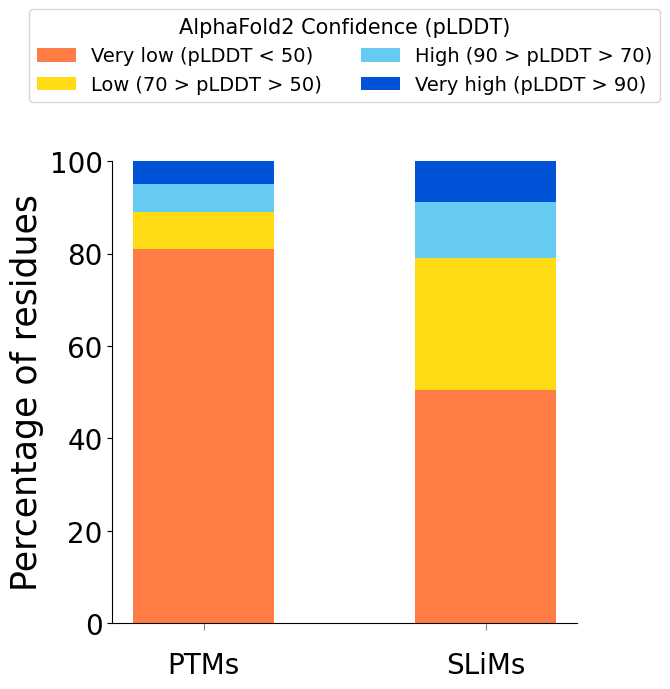

In [300]:
# Data for the first plot
bar_labels = ['PTMs', 'SLiMs']
categories1 = ['Very low (pLDDT < 50)','Low (70 > pLDDT > 50)','High (90 > pLDDT > 70)', 'Very high (pLDDT > 90)']



bins = [0, 50, 70, 90, float('inf')]
labels = ['x<50', '50<x<=70', '70<x<=90', 'x>90']

ptm_counts = [round(x/df_PTM_proteomeConf3D.shape[0], 2)*100 for x in pd.cut(df_PTM_proteomeConf3D['pLDDT'], bins=bins, labels=labels, right=False).value_counts().to_dict().values()]
slim_counts = [x/df_ELM_data.shape[0]*100 for x in pd.cut(df_ELM_data['pLDDT'], bins=bins, labels=labels, right=False).value_counts().to_dict().values()]
values = np.array([ptm_counts,slim_counts ])  # percentages for each group

# Ensure that each bar adds up to 100%
assert np.all(values.sum(axis=1) == 100), "Each bar must add up to 100%"

# Plotting
fig, ax= plt.subplots(figsize=(6, 6))

# Plot for the first dataset
bar_width = 0.1
bar_positions1 = [0.85, 1.05]
bottom1 = np.zeros(len(bar_labels))
colors_pLDDT1 = ['#FF7D45', '#FFDB13', '#65CBF3', '#0053D6']

for i in range(len(categories1)):
    ax.bar(bar_positions1, values[:, i], bar_width, bottom=bottom1, label=categories1[i], color=colors_pLDDT1[i])
    bottom1 += values[:, i]

# Customize the first plot
#ax.set_xlabel('GEMME per-residue confidence', fontsize=20, labelpad=15)
ax.set_ylabel('Percentage of residues', fontsize=25)
ax.set_xticks(bar_positions1)
ax.set_xticklabels(bar_labels, fontsize=20)
ax.tick_params(axis='x', which='major', length=5, pad=15, color='grey')
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
ax.set_ylim(0, 100)
ax.legend(fontsize=14,title='AlphaFold2 Confidence (pLDDT)', title_fontsize=15, ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.35))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
plt.savefig(f'{WORK_DIR}/Plots/SliM_PTM_pLDDT_Distrib.jpg', bbox_inches='tight', dpi=900)
plt.show()

In [193]:
sum(ptm_counts[:2]),sum(slim_counts[:2])

(89.0, 79.12087912087912)

59 61
Text(-0.021479163681230748, -0.6010424584432674, 'Global sensitivity') (-0.021479163681230748, -0.6010424584432674)
Text(0.02077492880643629, -0.6102193213743563, 'Local sensitivity') (0.02077492880643629, -0.6102193213743563)


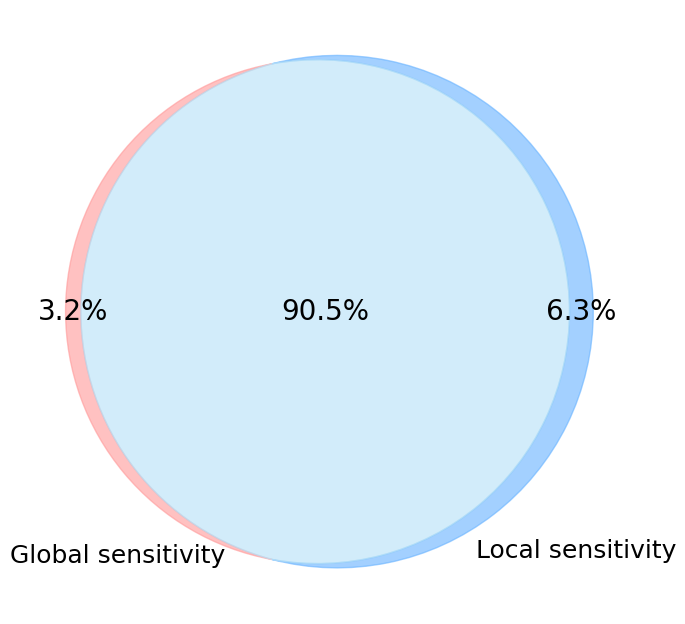

In [246]:
# Example sets of residues for three groups
groupSensitiveG = set(df_ELM_data[(df_ELM_data['pLDDT']<70)&(df_ELM_data['Global_Sensitivity'] != 0)].index)
groupSensitiveL = set(df_ELM_data.loc[(df_ELM_data['pLDDT']<70)& (df_ELM_data['Local_Sensitivity']!=0)].index)

print(len(groupSensitiveG), len(groupSensitiveL))


# Plotting the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn2([groupSensitiveG, groupSensitiveL], ('Global sensitivity', 'Local sensitivity'),  alpha=0.5)


# Custom colors for each section
colors = {
    '100': '#FF9999',  # Only Local Sensitivity
    '010': '#66B2FF',  # Only Global Sensitivity
    '110': '#B4E0F7',  
}

for subset in colors:
    if venn.get_label_by_id(subset):  # If the subset exists
        venn.get_patch_by_id(subset).set_color(colors[subset])
        venn.get_patch_by_id(subset).set_alpha(0.6)  # Adjust transparency if needed



# Calculate the total number of elements
total_elements = len(groupSensitiveG | groupSensitiveL)

# Adjust the labels to show percentages
for idx, subset in enumerate(venn.subset_labels):
    if subset:  # Check if the subset label is not None
        count = int(subset.get_text())
        percentage = (count / total_elements) * 100
        subset.set_text(f'{percentage:.1f}%')

# Adjust the font size of the labels
for text in venn.set_labels:
    text.set_fontsize(18)
    if text.get_text()=='Global sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]-0.2, text.get_position()[1]+0.1))
    if text.get_text()=='Local sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]+0.3, text.get_position()[1]+0.12))

for text in venn.subset_labels:
    if text:  # Check if the text object is not None
        text.set_fontsize(20)
    
#plt.title("Venn Diagram of PTM Residues with Functional Signals in Different Groups", fontsize=16)
plt.savefig(f'{WORK_DIR}/Plots/SLiMVennDiagram_GlobalLocalSens_IDR.jpg', dpi=400)
plt.show()

Text(-0.2793426995093532, 0.5272452196438073, 'Global sensitivity') (-0.2793426995093532, 0.5272452196438073)
Text(0.27519676955689204, 0.5358293888871873, 'Local sensitivity') (0.27519676955689204, 0.5358293888871873)
Text(0.09787738152151189, -0.34593599694127247, '12.5%') (0.09787738152151189, -0.34593599694127247)
Text(-0.4864584872277064, 0.005023293573519455, '2.8%') (-0.4864584872277064, 0.005023293573519455)
Text(0.4659107688071064, -0.005443985730072312, '5.6%') (0.4659107688071064, -0.005443985730072312)
Text(-0.008511091908765589, 0.0165229195187289, '79.2%') (-0.008511091908765589, 0.0165229195187289)


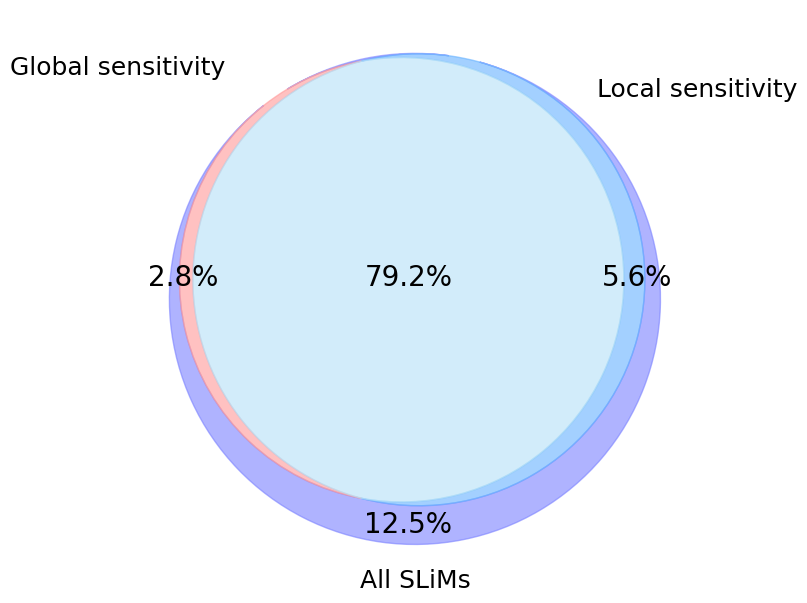

In [245]:
# Example sets of residues for three groups
groupSensitiveGEMME = set(df_ELM_data.loc[(df_ELM_data['pLDDT']<70)&(df_ELM_data['Global_Sensitivity'] != 0)].index)
groupSegGEMME = set(df_ELM_data.loc[(df_ELM_data['pLDDT']<70)&(df_ELM_data['Local_Sensitivity']!=0)].index)
groupAll = set(df_ELM_data.loc[(df_ELM_data['pLDDT']<70)].index)

# Plotting the Venn diagram with custom colors
plt.figure(figsize=(8, 8))
venn = venn3([groupSensitiveGEMME, groupSegGEMME, groupAll], ('Global sensitivity', 'Local sensitivity', 'All SLiMs'))

# Custom colors for each section
colors = {
    '100': '#FF9999',  # Only Local Sensitivity
    '010': '#66B2FF',  # Only Global Sensitivity
    '001': '#7A81FF',  # Only All PTMs
    '110': '#B4E0F7',  # Local & Global Sensitivity
    '101': '#FF9999',  # Local Sensitivity & All PTMs
    '011': '#66B2FF',  # Global Sensitivity & All PTMs
    '111': '#B4E0F7',  # Intersection of all three  D6D6D6
}

for subset in colors:
    if venn.get_label_by_id(subset):  # If the subset exists
        venn.get_patch_by_id(subset).set_color(colors[subset])
        venn.get_patch_by_id(subset).set_alpha(0.6)  # Adjust transparency if needed

# Calculate the total number of elements
total_elements = len(groupAll)

# Adjust the labels to show percentages
for idx, subset in enumerate(venn.subset_labels):
    if subset:  # Check if the subset label is not None
        count = int(subset.get_text())
        percentage = (count / total_elements) * 100
        subset.set_text(f'{percentage:.1f}%')

    # Adjust the font size of the labels
for text in venn.set_labels:
    text.set_fontsize(18)

    if text.get_text()=='Global sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]-0.15, text.get_position()[1]-0.04))
        
    if text.get_text()=='Local sensitivity':
        print(text, text.get_position())
        text.set_position((text.get_position()[0]+0.15, text.get_position()[1]-0.1))


for text in venn.subset_labels:
    if text:  # Check if the text object is not None
        text.set_fontsize(20)
        if '5.6%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0]+0.05, 0.02))  # Adjust the position
        if '79.2%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0], 0.02))  # Adjust the position
        if '2.8%' == text.get_text():
            print(text, text.get_position())
            text.set_position((text.get_position()[0]-0.04, 0.02))  # Adjust the position
        if '12.5%' == text.get_text():
            print(text, text.get_position())
            text.set_position((-0.008511091908765589, text.get_position()[1]-0.2))  # Adjust the position

plt.tight_layout()
#plt.title("Venn Diagram of PTM Residues with Functional Signals in Different Groups", fontsize=16)
plt.savefig(f'{WORK_DIR}/Plots/SLiMVennDiagram_GlobalLocalSens_IDR_AllPTMs.jpg', dpi=500)
plt.show()


## Discussion part:
we need some estimation somewhere of the proportion of the regions with plddt>70 that have high evolutionary pressure. This can be done by focusing on segments labelled 2 and comprising at least 5 residues. Give number of segments and fraction of plddt>70 that they represent. Just to make it clear that it's not EVERYTHING and give an idea of what's to be discovered.

In [281]:
df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_4.csv')
print(df_Segmentation['protein'].nunique())
df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
l_prot3D = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True)&(~df_Dmel_recap['Structure_3D_file'].isnull())].index.tolist()
print(len(l_prot3D))
df_Segmentation = df_Segmentation.loc[(df_Segmentation['FBpp_ID'].isin(l_prot3D))& (df_Segmentation['type']=='GEMME')].copy()
## keep only segments 2 and of 5 aa at least
df_Segmentation['segment_length'] = df_Segmentation['end'] - df_Segmentation['start'] + 1
df_Segmentation = df_Segmentation.loc[(df_Segmentation['segment_length']>=5)&(df_Segmentation['state']==2)].copy()

22169
19212


In [296]:
df_Segmentation = pd.read_csv(f'{WORK_DIR}/csv/Segmentation_ALL_a1_4.csv')
print(df_Segmentation['protein'].nunique())
df_Segmentation.rename(columns={'protein':'FBpp_ID'}, inplace=True)
l_prot3D = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True)&(~df_Dmel_recap['Structure_3D_file'].isnull())].index.tolist()
print(len(l_prot3D))
df_Segmentation = df_Segmentation.loc[(df_Segmentation['FBpp_ID'].isin(l_prot3D))& (df_Segmentation['type']=='GEMME')].copy()
## keep only segments 2 and of 5 aa at least
df_Segmentation['segment_length'] = df_Segmentation['end'] - df_Segmentation['start'] + 1
df_Segmentation.loc[(df_Segmentation['segment_length']>=5)].shape

22169
19212


(363791, 7)

In [299]:
51715/363791

0.14215579824679556

In [292]:
df_Segmentation.shape

(130634, 9)

In [283]:
for FBpp in df_Segmentation['FBpp_ID'].unique():
    gemme_plddt = pd.read_csv(f'../Seg/{FBpp}_GEMME_pLDDT.csv')
    print(FBpp)
    gemme_plddt['pLDDT'] = gemme_plddt['pLDDT']*100
    for index, row in df_Segmentation.loc[df_Segmentation['FBpp_ID'] == FBpp].iterrows():
        if all(gemme_plddt.loc[(gemme_plddt['Residue'] >= row['start']) & 
                               (gemme_plddt['Residue'] <= row['end']), 'pLDDT'] < 70):
            df_Segmentation.loc[index, 'pLDDT'] = 'low'
        else:
            df_Segmentation.loc[index, 'pLDDT'] = None


FBpp0070000
FBpp0070002
FBpp0070005
FBpp0070006
FBpp0070007
FBpp0070025
FBpp0070026
FBpp0070027
FBpp0070031
FBpp0070034
FBpp0070035
FBpp0070037
FBpp0070041
FBpp0070045
FBpp0070051
FBpp0070054
FBpp0070056
FBpp0070059
FBpp0070062
FBpp0070064
FBpp0070066
FBpp0070070
FBpp0070071
FBpp0070072
FBpp0070073
FBpp0070074
FBpp0070075
FBpp0070076
FBpp0070078
FBpp0070080
FBpp0070083
FBpp0070084
FBpp0070086
FBpp0070087
FBpp0070088
FBpp0070094
FBpp0070095
FBpp0070097
FBpp0070098
FBpp0070101
FBpp0070102
FBpp0070103
FBpp0070104
FBpp0070105
FBpp0070111
FBpp0070112
FBpp0070115
FBpp0070116
FBpp0070117
FBpp0070118
FBpp0070126
FBpp0070128
FBpp0070129
FBpp0070130
FBpp0070133
FBpp0070134
FBpp0070141
FBpp0070142
FBpp0070143
FBpp0070146
FBpp0070150
FBpp0070154
FBpp0070155
FBpp0070156
FBpp0070158
FBpp0070160
FBpp0070163
FBpp0070165
FBpp0070166
FBpp0070168
FBpp0070169
FBpp0070170
FBpp0070171
FBpp0070172
FBpp0070173
FBpp0070174
FBpp0070175
FBpp0070176
FBpp0070177
FBpp0070178
FBpp0070180
FBpp0070181
FBpp0070182
FBpp

In [ ]:
we have 130 634 segments at least 5 aa long and in state 2, 59 454 of them are entirely in pLDDT < 70 regions. 

In [287]:
df_Segmentation['contains_PTM'] = df_Segmentation.apply(
    lambda row: any((df_PTM_proteomeConf3D['FBpp_ID'] == row['FBpp_ID']) & 
                    (df_PTM_proteomeConf3D['position'] >= row['start']) & 
                    (df_PTM_proteomeConf3D['position'] <= row['end'])), axis=1)

In [289]:
df_Segmentation.loc[df_Segmentation['contains_PTM']==True].shape[0], df_Segmentation.loc[df_Segmentation['contains_PTM']==True].shape[0]/df_Segmentation.shape[0]*100

(10873, 8.323254282958494)

In [295]:
df_Segmentation.loc[(df_Segmentation['contains_PTM']==False) &(df_Segmentation['pLDDT']=='low')].shape[0], df_Segmentation.loc[(df_Segmentation['contains_PTM']==False) &(df_Segmentation['pLDDT']=='low')].shape[0]/df_Segmentation.shape[0]*100

(51715, 39.58770304821103)

In [291]:
df_Segmentation.to_csv(f'{WORK_DIR}/csv/Segmentation_Seg2_5aa_Confident3D.csv', index=False)

##  Elodie's suggestion: P10041 protein -  Dl-PA (identical isoforms Dl-PB, Dl-PC) 
        - 833 aa
        - Fobs = 87.12
        FBpp0083153
        

## Plot Segmentation

In [314]:
def plot_segmentation(FBppDir, segments, output, ptm=pd.DataFrame(), width=20, height=5):
    segments_grouped = segments.groupby('FBpp_ID')

    for protein, group in segments_grouped:
        data = pd.read_csv(os.path.join(FBppDir, f"{protein}_GEMME_pLDDT.csv"))
        signal = pd.DataFrame({
            'x': list(range(1, len(data) + 1)),
            'y': list(data['GEMME_mean']),
            'type': ['GEMME'] * len(data)
        })

        gemme = group[group['type'] == 'GEMME']
        cp = pd.DataFrame({
            'x': list(gemme['end'][:-1]),'type': ['GEMME'] * (len(gemme) - 1)})
        mean = pd.DataFrame({
            'x': list(gemme['start'] - 1),'xend': list(gemme['end']),
            'y': list(gemme['mean']),'type': ['GEMME'] * len(gemme),
            'state': list(gemme['state'])
        })

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height), gridspec_kw={'height_ratios': [1, 6]})
        # Plot GEMME on the top subplot
        for _, row in mean[mean['type'] == 'GEMME'].iterrows():
            ax2.axvspan(row['x'], row['xend'], color='white' if row['state'] == 0 else 'red' if row['state'] == 1 else 'purple', alpha=0.1)
        ax2.plot(signal[signal['type'] == 'GEMME']['x'], signal[signal['type'] == 'GEMME']['y'], label='GEMME', linewidth=1.3)
        for _, row in cp[cp['type'] == 'GEMME'].iterrows():
            ax2.axvline(row['x'], color='red', alpha=0.9, linewidth=1.3)
        for _, row in mean[mean['type'] == 'GEMME'].iterrows():
            ax2.plot([row['x'], row['xend']], [row['y'], row['y']], color='black',linewidth=1, alpha=0.75)
        ax2.set_ylabel('Average GEMME score', fontsize=17, labelpad=10)
        ax2.set_xlim(1, len(data))

        
        palette_bis={0:'#FF7D45', 1:'#FFDB13', 2:'#65CBF3', 3:'#0053D6'}
        bins = [0, 50, 70, 90, 100]
        df = pd.DataFrame(list(data['pLDDT']*100), columns=['value'])
        # Bin the values into groups
        df['group'] = pd.cut(df['value'], bins=bins, labels=[0,1,2,3], right=False)
        grouped_values_numeric = np.array(df['group'])

        # Reshape to a one-row matrix with 395 columns
        data_matrix = grouped_values_numeric.reshape(1, -1)

        # Map the palette to colors for the heatmap
        colors = [palette_bis[val] for val in sorted(palette_bis.keys())]
        cmap = sns.color_palette(colors, len(colors))
        sns.heatmap(data_matrix, cmap=cmap, linewidths=0, cbar=False, xticklabels=False, yticklabels=False, alpha=0.85, ax=ax1)


        # Adjust xticks for ax2
        xticks = range(50, len(data) + 1, 50)
        ax2.set_xticks(xticks)
        ax2.set_xticklabels([str(x) for x in xticks], fontsize=15)
        ax2.set_yticklabels([str(round(x, 1)) for x in ax2.get_yticks()], fontsize=15)

        # Remove x-axis ticks and labels from ax1
        ax1.set_xticks([])
        ax1.set_xticklabels([])
        ax1.set_xlim(1, len(data))
        ax2.set_xlim(1, len(data))


    
        for _, row in ptm.iterrows():
            ax2.axvline(int(row['position']), linestyle='--', color='lightgrey')
            #ax2.text(int(row['position']), max(signal['y']) + 0.1, 'P', ha='center', va='bottom', fontsize=12, color='black', bbox=dict(boxstyle='circle,pad=0.3', edgecolor='black', facecolor='none'))
            #ax2.axvline(int(row['position']),linestyle='--', color='lightgrey')
        
        plt.xlabel('Residue index', fontsize=20, labelpad=12)
        plt.subplots_adjust(hspace=0.05)
        plt.tight_layout()

        plt.savefig(output, dpi=500)
        plt.close(fig)


In [316]:
import matplotlib.patches as patches

def plot_segmentation_zoom(FBppDir, segments, output, ptm=pd.DataFrame(), width=20, height=6, l_lysines=[], sensitive_residues=[], l_motifs=[],l_ptm={}, domain =[], zoom_start=None, zoom_end=None):
    segments_grouped = segments.groupby('FBpp_ID')

    for protein, group in segments_grouped:
        data = pd.read_csv(os.path.join(FBppDir, f"{protein}_GEMME_pLDDT.csv"))

        if zoom_start is not None and zoom_end is not None:
            data = data.iloc[zoom_start-1:zoom_end]
        else:
            zoom_start=0; zoom_end=data.shape[0]

        signal = pd.DataFrame({
            'x': list(range(1, len(data) + 1)),
            'y': list(data['GEMME_mean']),
            'type': ['GEMME'] * len(data)
        })

        gemme = group[group['type'] == 'GEMME']
        cp = pd.DataFrame({
            'x': list(gemme['end'][:-1] - (zoom_start - 1 if zoom_start else 0)),
            'type': ['GEMME'] * (len(gemme) - 1)
        })
        mean = pd.DataFrame({
            'x': list(gemme['start'] - 1 - (zoom_start - 1 if zoom_start else 0)),
            'xend': list(gemme['end'] - (zoom_start - 1 if zoom_start else 0)),
            'y': list(gemme['mean']),
            'type': ['GEMME'] * len(gemme),
            'state': list(gemme['state'])
        })

        fig, ax1 = plt.subplots(1, 1, figsize=(width, height))
        # Plot GEMME on the subplot
        ##GEMME mean score 
        ax1.plot(signal[signal['type'] == 'GEMME']['x'], signal[signal['type'] == 'GEMME']['y'], label='GEMME')
        ## colored segments 
        for _, row in mean[mean['type'] == 'GEMME'].iterrows():
            ax1.axvspan(row['x']+0.5, row['xend']+0.5, color='white' if row['state'] == 0 else 'red' if row['state'] == 1 else 'purple', alpha=0.05)
        
        ## segments' borders and means
        for _, row in cp[cp['type'] == 'GEMME'].iterrows():
            ax1.axvline(row['x']+0.5, color='red', alpha=0.9, linewidth=1.3)
        for _, row in mean[mean['type'] == 'GEMME'].iterrows():
            ax1.plot([row['x']+0.5, row['xend']+0.5], [row['y'], row['y']], color='black',linewidth=1, alpha=0.75)
        #ax1.legend(loc='upper right', fontsize=15)

        # Remove x-axis ticks and labels from ax1
        ax1.set_xlim(1, len(data))
        ax1.set_ylim(0.0, 0.7)
        ax1.set_xticks(range(2, len(data) + 1, 10), labels=[str(round(x+1)) for x in range(zoom_start, zoom_end+1, 10)], fontsize=15)
        ax1.set_yticks(np.arange(0, 0.8, 0.1), labels=[str(round(x, 1)) for x in np.arange(0, 0.8, 0.1)], fontsize=15)
        #ax1.set_xticks([])
        #ax1.set_yticks([])
        #ax1.tick_params(axis='y', pad=7)
        
        
        # Add 'K' in circles above the plot at residues from l_lysines
        for lysine in l_lysines:
            ax1.text(lysine - (zoom_start - 1 if zoom_start else 0), max(signal['y']) + 0.09, 'K', ha='center', va='bottom', fontsize=13, color='black', bbox=dict(boxstyle='circle,pad=0.3', edgecolor='black', facecolor='none'))

        # Add small yellow stars for sensitive residues
        for residue, aa in l_ptm.items():
            ax1.text(residue - (zoom_start - 1 if zoom_start else 0), max(signal['y']) + 0.125, aa, ha='center', va='bottom', fontsize=13, color='black', bbox=dict(boxstyle='circle,pad=0.3', edgecolor='black', facecolor='none'))


        # Add small yellow stars for sensitive residues
        for residue in sensitive_residues:
            ax1.plot(residue - (zoom_start - 1 if zoom_start else 0), max(signal['y']) + 0.05, marker='*', color='black', alpha=0.5, markersize=11, fillstyle='none')

        # Draw dashed lines between common residues from l_lysines and sensitive_residues
        common_residues = set(l_lysines).intersection(sensitive_residues)
        for residue in common_residues:
            ax1.axvline(residue - (zoom_start - 1 if zoom_start else 0), color='gray', linestyle='--', ymin= max(signal['y']) + 0.3, ymax= max(signal['y']) + 0.3255)

        # Add squares for ICD motifs
        cpt=1
        for start, end in l_motifs:
            start_adj = max(start - (zoom_start - 1 if zoom_start else 0), 0); end_adj = min(end - (zoom_start - 1 if zoom_start else 0), len(data))
            rectangle = patches.Rectangle((start_adj, max(signal['y']) + 0.17), end_adj - start_adj, 0.025, linewidth=1, edgecolor='black', facecolor='black', alpha=0.5)
            ax1.add_patch(rectangle)
            plt.text(start_adj + (end_adj - start_adj) / 2, max(signal['y']) + 0.18, f'ICD{cpt}', ha='center', va='center', fontsize=12, color='white')
            cpt+=1

        ## add a rectungle for the domain 
        for domain_start, domain_end in domain: 
        
            start_adj = max(domain_start - (zoom_start - 1 if zoom_start else 0), 0)
            end_adj = min(domain_end - (zoom_start - 1 if zoom_start else 0), len(data))
            rectangle = patches.Rectangle((start_adj, max(signal['y']) + 0.13), end_adj - start_adj, 0.025, linewidth=1, edgecolor='firebrick', facecolor='firebrick', alpha=0.5)
            ax1.add_patch(rectangle)
            plt.text(start_adj + (end_adj - start_adj) / 2, max(signal['y']) + 0.14, f'4XIB', ha='center', va='center', fontsize=12, color='white') 

        plt.xlabel('Residue index', fontsize=20, labelpad=12)
        plt.ylabel('Average GEMME score', fontsize=18, labelpad=12)
        plt.tight_layout()
        plt.savefig(output, dpi=500)
        plt.close(fig)


In [315]:
# Example usage
FBppDir = '../Seg/'
FBpp_ID = 'FBpp0083153'
segments = df_Segmentation.loc[df_Segmentation['FBpp_ID']=='FBpp0083153']
output = f'../Plots/FBpp0083153_Seg.jpg'
#ptm = df_PTM_proteome.loc[df_PTM_proteome['FBpp_ID']=='FBpp0301274'].copy()
#d_mutations = {row['Mutation_Fobs']: (row['GEMME_Value_Fobs'], row['Set_name']) for k, row in df_Benchmark.loc[df_Benchmark['FBpp_ID_Fobs']=='FBpp0083153'][['Mutation_Fobs', 'GEMME_Value_Fobs', 'Set_name']].iterrows()}
plot_segmentation(FBppDir, segments, output)

/var/folders/v9/tv7qw0pd675c44_m3d98bz_c0000gn/T/ipykernel_30692/26905566.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(round(x, 1)) for x in ax2.get_yticks()], fontsize=15)


In [317]:
# Example usage
FBpp='FBpp0083153'
##output
output = f'../Plots/{FBpp}_zoomSeg.png'
segments = df_Segmentation.loc[df_Segmentation['FBpp_ID']=='FBpp0083153']


##ptm
ptm = df_PTM_proteome.loc[df_PTM_proteome['FBpp_ID']==FBpp].copy()

residues_K_paper = [629, 636, 665, 683, 688, 739, 742, 762, 775]

## sensitive residues 
id = df_mapping.loc[FBpp, 'id']
df_proteocast = pd.read_csv(f'{WORK_DIR}/Drosophila_ProteoCast/{id}/4.{FBpp}_ProteoCast.csv')
sensitive_columns = list(df_proteocast.loc[(df_proteocast['Residue']>628)&(df_proteocast['Residue_class']=='sensitive'), 'Residue'].unique())

d_ptm = {row['position']: row['AA'] for _, row in df_PTM_proteome.loc[df_PTM_proteome['FBpp_ID']==FBpp].iterrows()}
l_ICD_motifs = [(630, 641), (682, 693), (742, 747)]

plot_segmentation_zoom(FBppDir, segments, output, l_lysines=residues_K_paper,sensitive_residues=sensitive_columns, l_motifs=l_ICD_motifs, l_ptm = d_ptm, domain = [(680, 690)], zoom_start=629, zoom_end=833)


## CrebB pdb of 359 (Q9VWW0), isoform E but FBgn doesn't have this isoform 

In [ ]:
for index, row in df_UniIDmining.iterrows():
    modelPDB = gm.read_pdb(AF_dir+f'AF-{index}-F1-model_v4.pdb.gz')[0][0]
    pdb_sequence = ''.join(bfactorsPDB(modelPDB)["aa"].tolist())
    print(row['To'])
    for pp in df_Dmel_recap.loc[(df_Dmel_recap['FBgn_ID']==row['To'])&(df_Dmel_recap['Length']==len(pdb_sequence))].index:
        print('PP', pp)
        if dc_proten_seqs[pp].seq==pdb_sequence:
            df_Uniprot_FBpp.loc[pp, 'UniProt']=index


In [98]:
for x in l_diffSeq:
    uniprot= x.split('-')[1]
    modelPDB = gm.read_pdb(AF_dir+f'AF-{uniprot}-F1-model_v4.pdb.gz')[0][0]
    pdb_sequence = ''.join(bfactorsPDB(modelPDB)["aa"].tolist())
    for pp in df_Uniprot_FBpp.loc[df_Uniprot_FBpp['UniProt']==uniprot].index:
        print('PP', pp)
        if dc_proten_seqs[pp].seq!=pdb_sequence:
            print('TRUE')
            df_Uniprot_FBpp.loc[pp, 'UniProt']=np.nan

PP FBpp0070472
TRUE
PP FBpp0070473
TRUE
PP FBpp0070855
TRUE
PP FBpp0100045
TRUE
PP FBpp0100051
TRUE
PP FBpp0100050
TRUE
PP FBpp0100048
TRUE
PP FBpp0100047
TRUE
PP FBpp0082539
TRUE
PP FBpp0073249
TRUE
PP FBpp0070425
TRUE
PP FBpp0086640
TRUE
PP FBpp0073673
TRUE
PP FBpp0428255
PP FBpp0428256
PP FBpp0083395
TRUE
PP FBpp0070468
TRUE
PP FBpp0289082
TRUE
PP FBpp0071571
TRUE
PP FBpp0075123
TRUE
PP FBpp0070259
TRUE
PP FBpp0085761
TRUE
PP FBpp0087449
TRUE
PP FBpp0297062
TRUE
PP FBpp0087471
TRUE
PP FBpp0080484
TRUE
PP FBpp0070768
TRUE
PP FBpp0074373
TRUE
PP FBpp0309909
TRUE
PP FBpp0083863
TRUE
PP FBpp0072333
TRUE


In [94]:
for x in l_diffLength:
    uniprot= x.split('-')[1]
    modelPDB = gm.read_pdb(AF_dir+f'AF-{uniprot}-F1-model_v4.pdb.gz')[0][0]
    pdb_sequence = ''.join(bfactorsPDB(modelPDB)["aa"].tolist())
    for pp in df_Uniprot_FBpp.loc[df_Uniprot_FBpp['UniProt']==uniprot].index:
        print('PP', pp)
        if len(dc_proten_seqs[pp].seq)!=len(pdb_sequence):
            print('TRUE')
            df_Uniprot_FBpp.loc[pp, 'UniProt']=np.nan

PP FBpp0312344
TRUE
PP FBpp0293344
TRUE
PP FBpp0293897
TRUE
PP FBpp0073098
TRUE
PP FBpp0074805
TRUE
PP FBpp0312485
TRUE
PP FBpp0071932
TRUE
PP FBpp0075334
TRUE
PP FBpp0303767
TRUE
PP FBpp0428255
PP FBpp0428256
PP FBpp0312615
TRUE
PP FBpp0312613
TRUE
PP FBpp0113004
TRUE
PP FBpp0309075
TRUE
PP FBpp0312614
TRUE
PP FBpp0309625
TRUE
PP FBpp0079667
TRUE
PP FBpp0080927
TRUE
PP FBpp0086852
TRUE
PP FBpp0086567
TRUE
